In [1]:
from inference.snpe.snpe_c import SNPE_C as SNPE
from inference.base import *

import utils as utils
from utils.get_nn_models import *
from utils.sbiutils import *
from utils.torchutils import *
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from torch import nn
import seaborn as sns
import random
import pickle
import io
import utils.corruption as corruption
import utils.metrics as metrics
import copy
from simulators.ricker import ricker
from utils.corruption import magnitude_sigma
from networks.summary_nets import RickerSummary

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [2]:
matplotlib.rcParams.update({
    'font.family' : 'serif',
    'font.size' : 12.0,
    'lines.linewidth' : 2,
    'lines.antialiased' : True,
    'axes.facecolor': 'fdfdfd',
    'axes.edgecolor': '777777',
    'axes.linewidth' : 1,
    'axes.titlesize' : 'medium',
    'axes.labelsize' : 'medium',
    'axes.axisbelow' : True,
    'xtick.major.size'     : 0,      # major tick size in points
    'xtick.minor.size'     : 0,      # minor tick size in points
    'xtick.major.pad'      : 6,      # distance to major tick label in points
    'xtick.minor.pad'      : 6,      # distance to the minor tick label in points
    'xtick.color'          : '333333', # color of the tick labels
    'xtick.labelsize'      : 'medium', # fontsize of the tick labels
    'xtick.direction'      : 'in',     # direction: in or out
    'ytick.major.size'     : 0,      # major tick size in points
    'ytick.minor.size'     : 0,      # minor tick size in points
    'ytick.major.pad'      : 6,      # distance to major tick label in points
    'ytick.minor.pad'      : 6,      # distance to the minor tick label in points
    'ytick.color'          : '333333', # color of the tick labels
    'ytick.labelsize'      : 'medium', # fontsize of the tick labels
    'ytick.direction'      : 'in',     # direction: in or out
    'axes.grid' : False,
    'grid.alpha' : 0.3,
    'grid.linewidth' : 1,
    'legend.fancybox' : True,
    'legend.fontsize' : 'Small',
    'figure.figsize' : (5, 4),
    'figure.facecolor' : '1.0',
    'figure.edgecolor' : '0.5',
    'hatch.linewidth' : 0.1,
    'text.usetex' : False
    })

color_map = {'green': '#009E60', 'orange': '#C04000',
              'blue': 'C0', 'black':'#3A3B3C',
              'purple': '#843B62', 'red': '#C41E3A'}

In [3]:
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else: return super().find_class(module, name)

        
def load_models(root_name: str, device: torch.device):
    sum_net = torch.load(f"{root_name}/sum_net.pkl", map_location=device)

    density_estimator = torch.load(f"{root_name}/density_estimator.pkl", map_location=device)

    with open(f"{root_name}/posterior.pkl", "rb") as handle:
        posterior = CPU_Unpickler(handle).load() if device == torch.device('cpu') else pickle.load(handle)
    
    return sum_net, density_estimator, posterior


def read_rnpe(model="ricker", misspecified=0, seed=1, theta=[4,10]):
    file = f"seed={seed}_var={misspecified}_theta={theta}_{model}"

    results_dir = f"objects/rnpe/{model}/"
    fn = f"{results_dir}/{file}.pickle"

    with open(fn, "rb") as f:
        results = pickle.load(f)

    return np.array(results['posterior_samples']['RNPE'])


def sample_posteriors(posterior, obs, num):
    return posterior.sample((num,), x=obs.reshape(1, 1, 100, 100), show_progress_bars=False)

In [4]:
def RMSE(gt, samples, p=1):
    if p == 1:
        dist = torch.mean(torch.abs(gt-samples))
    elif p == 2:
        dist = torch.sqrt(torch.mean((gt-samples)**2))
    elif p == 3:
        dist = torch.nn.functional.pairwise_distance(gt, samples, p=2).mean()
    else:
        dist = metrics.MMD_unweighted(samples, gt.reshape(-1, 2), lengthscale=metrics.median_heuristic(samples))
    return dist

In [5]:
theta_gt = torch.tensor([4, 10])
obs = ricker(theta_gt).to(device)

x = torch.tensor(np.load("data/ricker_x_4000.npy")).reshape(-1, 100, 100).to(device)
theta = np.load("data/ricker_theta_4000.npy")

p = 2

# var = 0

NPE-RS (ours):  1.9359919607639313
RNPE:  3.17205712000529
NPE:  2.2989792828758557


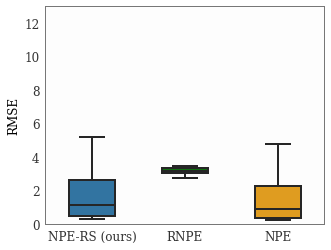

In [25]:
sigma = torch.tensor([0])
obs_cont = corruption.magnitude_sigma(obs, var=sigma).reshape(-1, 100, 100)

beta_list = [2.0]
dist_ours = []
dist_npe = []
dist_rnpe = []
for i in range(1, 31):
    for beta in beta_list:
        root_name = f"objects/ricker/var=0.0_mmd_beta={beta}_theta=[4, 10]_num=1000/{i}"
        _, _, posterior_robust = load_models(root_name, device)
        thetas_robust = sample_posteriors(posterior_robust, obs_cont, 1000)
        dist_ours.append(float(RMSE(theta_gt, thetas_robust, p=p)))
    
    root_name = f"objects/ricker/npe_num=1000/{i}"
    _, _, posterior_normal = load_models(root_name, device)
    
    thetas_npe = sample_posteriors(posterior_normal, obs_cont, 1000)
    dist_npe.append(float(RMSE(theta_gt, thetas_npe, p=p)))
    
    thetas_rnpe = torch.tensor(read_rnpe(model="ricker", misspecified=0, seed=i, theta='[4,10]'))[:1000]
    dist_rnpe.append(float(RMSE(theta_gt, thetas_rnpe, p=p)))

x = 30 * ["NPE-RS (ours)"] + 30 * ["RNPE"] + 30 * ["NPE"] 
y = np.array([dist_ours + dist_rnpe + dist_npe]).reshape(-1)

# print("beta = 1: ", sum(dist_ours[:30])/30)
print("NPE-RS (ours): ", sum(dist_ours)/30)
# print("beta = 3: ", sum(dist_ours[60:])/30)
print("RNPE: ", sum(dist_rnpe)/30)
print("NPE: ", sum(dist_npe)/30)

my_pal = {"NPE-RS (ours)": "C0", "RNPE": "green", "NPE":"orange"}
sns.boxplot(x=x, y=y, width=0.5, showfliers = False, palette=my_pal)
# plt.title("RMSE between $\\theta_\mathrm{true}$ and posterior of $\\theta$")
plt.ylabel("RMSE" if p==2 else "MAE")
plt.ylim(0, 13)
plt.savefig("ricker_0_rmse.pdf", bbox_inches = 'tight', dpi = 300)
plt.show()

# var = 20

NPE-RS (ours):  3.2402535378932953
RNPE:  4.278075313568115
NPE:  6.347694667180379


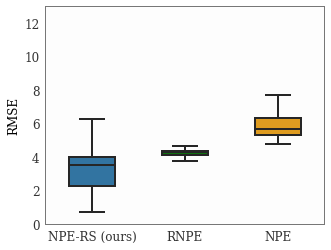

In [22]:
sigma = torch.tensor([20])
obs_cont = corruption.magnitude_sigma(obs, var=sigma).reshape(-1, 100, 100)

beta_list = [2.0]
dist_ours = []
dist_npe = []
dist_rnpe = []
for i in range(1, 31):
    for beta in beta_list:
        root_name = f"objects/ricker/var=20.0_mmd_beta={beta}_theta=[4, 10]_num=1000/{i}"
        _, _, posterior_robust = load_models(root_name, device)
        thetas_robust = sample_posteriors(posterior_robust, obs_cont, 1000)
        dist_ours.append(float(RMSE(theta_gt, thetas_robust, p=p)))
    
    root_name = f"objects/ricker/npe_num=1000/{i}"
    _, _, posterior_normal = load_models(root_name, device)
    
    thetas_npe = sample_posteriors(posterior_normal, obs_cont, 1000)
    dist_npe.append(float(RMSE(theta_gt, thetas_npe, p=p)))
    
    thetas_rnpe = torch.tensor(read_rnpe(model="ricker", misspecified=20, seed=i, theta='[4,10]'))[:1000]
    dist_rnpe.append(float(RMSE(theta_gt, thetas_rnpe, p=p)))

x = 30 * ["NPE-RS (ours)"] + 30 * ["RNPE"] + 30 * ["NPE"] 
y = np.array([dist_ours + dist_rnpe + dist_npe]).reshape(-1)

# print("beta = 1: ", sum(dist_ours[:30])/30)
print("NPE-RS (ours): ", sum(dist_ours)/30)
# print("beta = 3: ", sum(dist_ours[60:])/30)
print("RNPE: ", sum(dist_rnpe)/30)
print("NPE: ", sum(dist_npe)/30)

my_pal = {"NPE-RS (ours)": "C0", "RNPE": "green", "NPE":"orange"}
sns.boxplot(x=x, y=y, width=0.5, showfliers = False, palette=my_pal)
# plt.title("RMSE between $\\theta_\mathrm{true}$ and posterior of $\\theta$")
plt.ylabel("RMSE" if p==2 else "MAE")
plt.ylim(0, 13)
plt.savefig("ricker_20_rmse.pdf", bbox_inches = 'tight', dpi = 300)
plt.show()

# var = 40

NPE-RS (ours):  4.377421919504801
RNPE:  5.338454612096151
NPE:  9.817392603556316


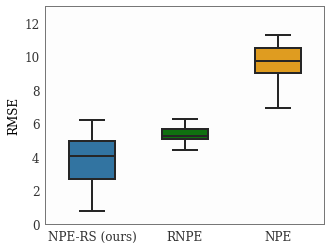

In [23]:
sigma = torch.tensor([40])
obs_cont = corruption.magnitude_sigma(obs, var=sigma).reshape(-1, 100, 100)

beta_list = [2.0]
dist_ours = []
dist_npe = []
dist_rnpe = []
for i in range(1, 31):
    for beta in beta_list:
        root_name = f"objects/ricker/var=40.0_mmd_beta={beta}_theta=[4, 10]_num=1000/{i}"
        _, _, posterior_robust = load_models(root_name, device)
        thetas_robust = sample_posteriors(posterior_robust, obs_cont, 1000)
        dist_ours.append(float(RMSE(theta_gt, thetas_robust, p=p)))
    
    root_name = f"objects/ricker/npe_num=1000/{i}"
    _, _, posterior_normal = load_models(root_name, device)
    
    thetas_npe = sample_posteriors(posterior_normal, obs_cont, 1000)
    dist_npe.append(float(RMSE(theta_gt, thetas_npe, p=p)))
    
    thetas_rnpe = torch.tensor(read_rnpe(model="ricker", misspecified=40, seed=i, theta='[4,10]'))[:1000]
    dist_rnpe.append(float(RMSE(theta_gt, thetas_rnpe, p=p)))

x = 30 * ["NPE-RS (ours)"] + 30 * ["RNPE"] + 30 * ["NPE"] 
y = np.array([dist_ours + dist_rnpe + dist_npe]).reshape(-1)

# print("beta = 1: ", sum(dist_ours[:30])/30)
print("NPE-RS (ours): ", sum(dist_ours)/30)
# print("beta = 3: ", sum(dist_ours[60:])/30)
print("RNPE: ", sum(dist_rnpe)/30)
print("NPE: ", sum(dist_npe)/30)

my_pal = {"NPE-RS (ours)": "C0", "RNPE": "green", "NPE":"orange"}
sns.boxplot(x=x, y=y, width=0.5, showfliers = False, palette=my_pal)
# plt.title("RMSE between $\\theta_\mathrm{true}$ and posterior of $\\theta$")
plt.ylabel("RMSE" if p==2 else "MAE")
plt.ylim(0, 13)
plt.savefig("ricker_40_rmse.pdf", bbox_inches = 'tight', dpi = 300)
plt.show()

# Beta analysis

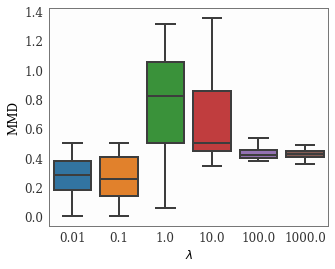

In [38]:
sigma = torch.tensor([20])
obs_cont = corruption.magnitude_sigma(obs, var=sigma).reshape(-1, 100, 100)

prior_samples = torch.tensor(theta[:1000])

betas = [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
# betas = [1.0, 2.0, 3.0, 5.0, 10.0, 100.0]
mmd_prior = []
mmd_npe = []
for beta in betas:
    for i in range(1, 31):
        root_name = f"objects/ricker/npe_num=1000/{i}"
        _, _, posterior_npe = load_models(root_name, device)
        post_samples_npe = sample_posteriors(posterior_npe, obs_cont, 1000)

        root_name = f"objects/ricker/var=40.0_mmd_beta={beta}_theta=[4, 10]_num=1000/{i}"
        _, _, posterior_robust = load_models(root_name, device)
        post_samples_robust = sample_posteriors(posterior_robust, obs_cont, 1000)
        
        mmd_npe.append(float(metrics.MMD_unweighted(post_samples_npe, post_samples_robust, lengthscale=metrics.median_heuristic(post_samples_npe))))
        mmd_prior.append(float(metrics.MMD_unweighted(prior_samples, post_samples_robust, lengthscale=metrics.median_heuristic(prior_samples))))
x = 30 * ["0.01"] + 30 * ["0.1"] + 30 * ["1.0"] + 30 * ["10.0"] + 30 * ["100.0"] + 30 * ["1000.0"]

sns.boxplot(x=x, y=mmd_npe, showfliers = False)
plt.ylabel("MMD")
plt.xlabel("$\lambda$")
# plt.title("MMD between NPE posterior and ours")
plt.savefig("lambda_check_npe.pdf", bbox_inches = 'tight', dpi = 300)
plt.show()


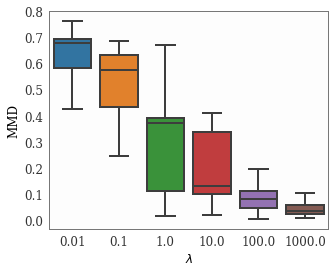

In [39]:
sns.boxplot(x=x, y=mmd_prior, showfliers = False)
plt.ylabel("MMD")
plt.xlabel("$\lambda$")
# plt.title("MMD between prior and ours")
plt.savefig("lambda_check_prior.pdf", bbox_inches = 'tight', dpi = 300)
plt.show()

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

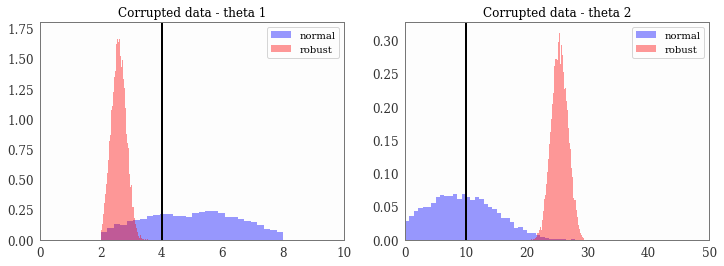

In [15]:
theta_gt = torch.tensor([4, 10])
obs = ricker(theta_gt).to(device)
sigma = torch.tensor([40])
obs_cont = corruption.magnitude_sigma(obs, var=sigma).reshape(-1, 100, 100)

root_name = "objects/ricker/var=40.0_mmd_beta=0.01_theta=[4, 10]_num=1000/5"
sum_net_robust, density_estimator_robust, posterior_robust = load_models(root_name, device)

root_name = "objects/ricker/var=40.0_mmd_beta=1000.0_theta=[4, 10]_num=1000/8"
sum_net_normal, density_estimator_normal, posterior_normal = load_models(root_name, device)

post_samples_normal_cont = posterior_normal.sample((10000,), x=obs_cont.reshape(1, 1, 100, 100))
post_samples_robust_cont = posterior_robust.sample((10000,), x=obs_cont.reshape(1, 1, 100, 100))


np.save("post_samples_beta1000.npy", post_samples_normal_cont.detach().numpy())
np.save("post_samples_beta0.01.npy", post_samples_robust_cont.detach().numpy())


plt.figure(figsize=(12,4))

plt.subplot(1, 2, 1)
plt.axvline(x=theta_gt[0],ls="-",c="black")
sns.distplot(post_samples_normal_cont[:, 0].cpu().numpy(), color='blue', kde=False, norm_hist=True, label="normal")
sns.distplot(post_samples_robust_cont[:, 0].cpu().numpy(), color='red', kde=False, norm_hist=True, label="robust")
plt.legend()
plt.xlim(0, 10)
plt.title("Corrupted data - theta 1")

plt.subplot(1, 2, 2)
plt.axvline(x=theta_gt[1],ls="-",c="black")
sns.distplot(post_samples_normal_cont[:, 1].cpu().numpy(), color='blue', kde=False, norm_hist=True, label="normal")
sns.distplot(post_samples_robust_cont[:, 1].cpu().numpy(), color='red', kde=False, norm_hist=True, label="robust")
plt.legend()
plt.xlim(0, 50)
plt.title("Corrupted data - theta 2")
plt.show()
